# Автоассоциативные сети с узким горлом

**Цель работы:**  исследование свойств автоассоциативных сетей с узким горлом,
алгоритмов обучения, а также применение сетей для выполнения линейного и нелинейного анализа главных компонент набора данных.



| <!-- --> | <!-- --> |
|:---------|:---------|
| Студент    | Почечура А.А.   |
| Группа   | М8О-406Б-20  |
| Вариант    | 18   |

Подключаем библиотеки, которые нам понадобятся в данной работе

In [2]:
import torch
import random
import numpy as np
import math
import matplotlib.pyplot as plt
import torch.nn as nn
from tqdm import tqdm

## Этап 1: Использовать автоассоциативную сеть с узким горлом для отображения набора данных,выделяя первую главную компоненту данных.

Сгенерируем множество точек согласно варианту. Отобразим результат на графике.

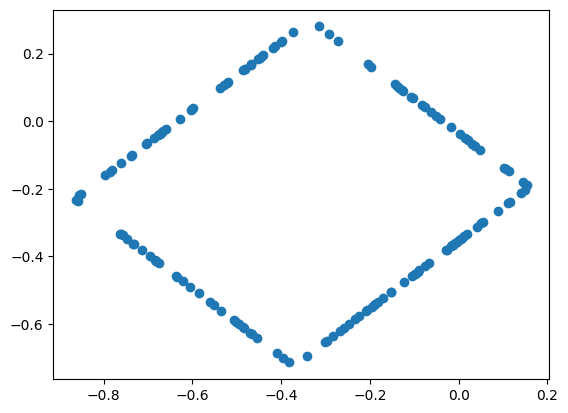

In [13]:
d1 = 0.7
d2 = 0.75
alfa = torch.pi/4
x_0 = -0.1
y_0 = -0.4

n = 150
angle = [random.uniform(0, 2 * math.pi) for i in range(n)]
data = torch.ones(n, 2)
cor = math.atan(d2/d1)
for i in range(n):
  if (angle[i] <= cor and angle[i]  >= 0):
    data[i, 0] = x_0+d1/2
    data[i, 1] = y_0+d1/2*math.tan(angle[i])
  elif (angle[i] <= 2*math.pi and angle[i]  >= 2*math.pi - cor):
    data[i, 0] = x_0+d1/2
    data[i, 1] = y_0+d1/2*math.tan(angle[i])
  elif (angle[i] <= math.pi-cor and angle[i]  >= cor):
    data[i, 0] = x_0+d2/2/math.tan(angle[i])
    data[i, 1] = y_0+d2/2
  elif (angle[i] <= math.pi+cor and angle[i]  >= math.pi-cor):
    data[i, 0] = x_0-d1/2
    data[i, 1] = y_0-d1/2*math.tan(angle[i])
  elif (angle[i] <= 2*math.pi -cor and angle[i]  >= cor+math.pi):
    data[i, 0] = x_0-d2/2/math.tan(angle[i])
    data[i, 1] = y_0-d2/2

rotation = torch.ones(2, 2)
rotation[0,0] = math.cos(alfa)
rotation[1,1] = math.cos(alfa)
rotation[0,1] = -math.sin(alfa)
rotation[1,0] = math.sin(alfa)

data = data @ rotation

plt.scatter(data[:,0], data[:,1])
plt.show()

Задаём параметры линейного слоя.

In [14]:
class Linear(nn.Module):
  def __init__(self, inputs, outputs):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(inputs, outputs))
    self.bias = nn.Parameter(torch.randn(outputs))

  def forward(self, x):
    x = x @ self.weights + self.bias
    return x

Создадим класс ANN, в котором будет описываться автоассоциативная сеть. Состоять она будет из двух линейных слоёв, функция активации *pureline*.

In [15]:
class ANN(nn.Module):
  def __init__(self, in_features, hidden_size):
    super().__init__()
    self.l1 = Linear(in_features, hidden_size)
    self.l2 = Linear(hidden_size, in_features)

  def forward(self, x):
    x = self.l1(x)
    x = self.l2(x)
    return x

Далее идёт класс Trainer, с помощью которого мы тренируем нашу сеть. Иницализируем класс параметрами обучения и определяем порядок обучения.

In [16]:
class Trainer():
  def __init__(self,  net, loss_f, learning_rate=1e-3,
              epoch_amount=10,
              optim=torch.optim.Adam):

    self.loss_f = loss_f
    self.learning_rate = learning_rate
    self.epoch_amount = epoch_amount
    self.optim = optim
    self.model = net

    self.train_loss = []

  def predict(self, X):
    with torch.no_grad():
      return self.model(X)

  def fit(self, x_train):
    Net = self.model
    optimizer = self.optim(Net.parameters(), lr=self.learning_rate)

    with tqdm(desc="epoch", total=self.epoch_amount) as bar:
      for epoch in range(self.epoch_amount):
        optimizer.zero_grad()
        predicted_values = Net(x_train)
        loss1 = self.loss_f(predicted_values, x_train)
        loss1.backward()
        optimizer.step()

        self.train_loss.append(loss1.detach().numpy())

        bar.set_postfix({"Loss_train": loss1.detach().numpy()})
        bar.update()

Производим обучение модели.

In [20]:
net = ANN(2,1)
train = Trainer(net, nn.MSELoss(), 0.1, 100, torch.optim.Adam)
train.fit(data)

epoch: 100%|██████████| 100/100 [00:00<00:00, 179.28it/s, Loss_train=0.043695584]


Отобразим на графике значения ошибок, полученных в процессе обучения модели.

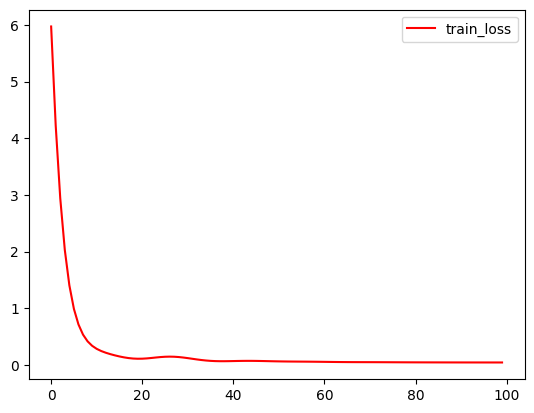

In [21]:
plt.plot(train.train_loss, "red", label='train_loss')
plt.legend()
plt.show()

Проиллюстрируем на графике полученные предсказанные значения:

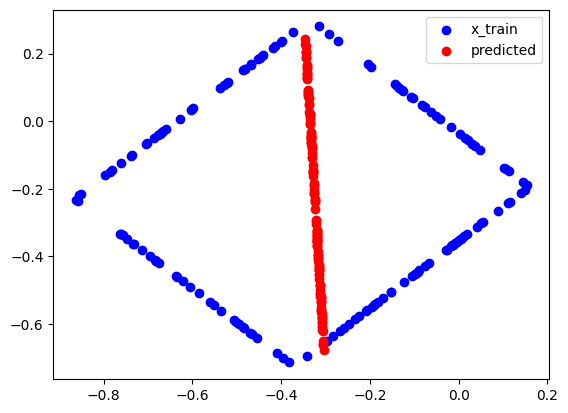

In [22]:
preds = train.predict(data)
plt.scatter(data[:,0], data[:,1], c='b' , label='x_train')
plt.scatter(preds[:,0], preds[:,1], c='r' , label='predicted')
plt.legend()
plt.show()

## Этап 2: использовать автоассоциативную сеть с узким горлом для аппроксимации кривой на плоскости, выделяя первую нелинейную главную компоненту данных.

Сгенерируем множество точек согласно варианту. Отобразим результат на графике.

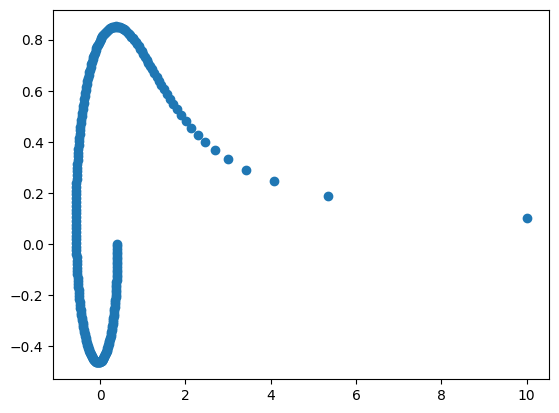

In [23]:
angle = torch.arange(0.01, 2*math.pi+0.025, 0.025)
data = torch.Tensor([[1/a**0.5*math.cos(a), 1/a**0.5*math.sin(a)]for a in angle])

plt.scatter(data[:,0], data[:,1])
plt.show()

Изменим класс ANN из прошлого этапа: добавим два дополнительных слоя, с помощью которых будем образовывать "узкое горлышко". Используемая функция активации - *Tanh*.

In [24]:
Tanh = nn.Tanh()
class ANN(nn.Module):
  def __init__(self, in_features, hidden_size1, hidden_size2, hidden_size3):
    super().__init__()
    self.l1 = Linear(in_features, hidden_size1)
    self.l2 = Linear(hidden_size1, hidden_size2)
    self.l3 = Linear(hidden_size2, hidden_size3)
    self.l4 = Linear(hidden_size3, in_features)

  def forward(self, x):
    x = Tanh(self.l1(x))
    x = Tanh(self.l2(x))
    x = Tanh(self.l3(x))
    x = self.l4(x)
    return x

Производим обучение модели. Количество нейронов в слоях соответствует значениям 10 -> 1 -> 10.

In [25]:
net = ANN(2,10, 1, 10)
train = Trainer(net, nn.MSELoss(), 0.1, 2000, torch.optim.Adam)
train.fit(data)

epoch: 100%|██████████| 2000/2000 [00:10<00:00, 184.93it/s, Loss_train=0.003004199]


Отобразим на графике значения ошибок, полученных в процессе обучения модели.

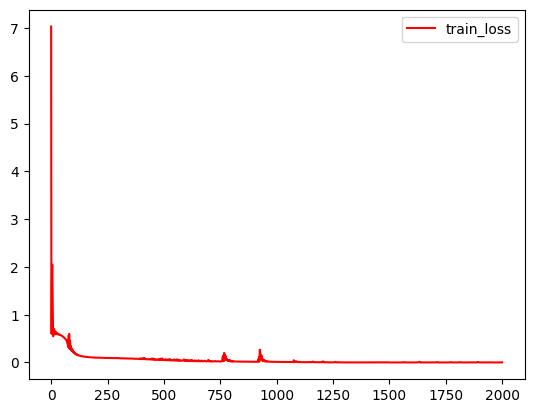

In [26]:
plt.plot(train.train_loss, "red", label='train_loss')
plt.legend()
plt.show()

Проиллюстрируем на графике полученные предсказанные значения в сравнении с действительными:

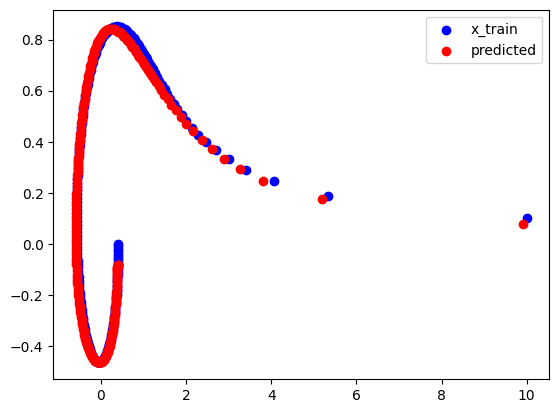

In [27]:
preds = train.predict(data)
plt.scatter(data[:,0], data[:,1], c='b' , label='x_train')
plt.scatter(preds[:,0], preds[:,1], c='r' , label='predicted')
plt.legend()
plt.show()

### Этап 3.

Изменим данные из прошлого этапа, сделав их трёхмерными.

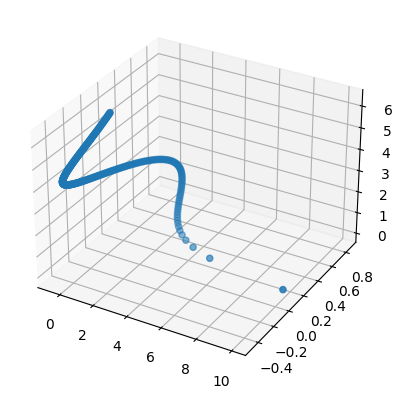

In [28]:
angle = torch.arange(0.01, 2*math.pi+0.025, 0.025)
data = torch.Tensor([[1/a**0.5*math.cos(a), 1/a**0.5*math.sin(a), a]for a in angle])

ax = plt.axes(projection='3d')
ax.scatter3D(data[:,0], data[:,1], data[:,2])

Производим обучение модели. Количество нейронов в слоях соответствует значениям 10 -> 2 -> 10.

In [29]:
net = ANN(3,10, 2, 10)
train = Trainer(net, nn.MSELoss(), 0.1, 1000, torch.optim.Adam)
train.fit(data)

epoch: 100%|██████████| 1000/1000 [00:05<00:00, 196.03it/s, Loss_train=0.008930639]


Отобразим на графике значения ошибок, полученных в процессе обучения модели.

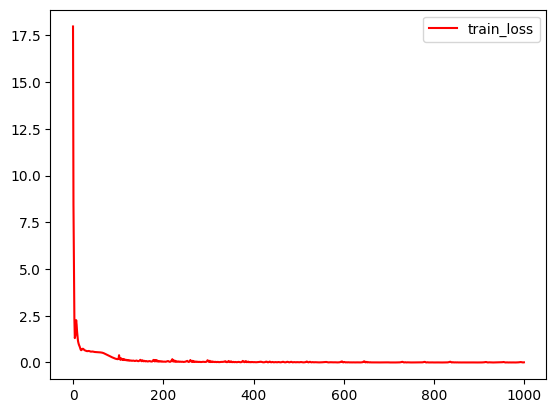

In [30]:
plt.plot(train.train_loss, "red", label='train_loss')
plt.legend()
plt.show()

Проиллюстрируем на графике полученные предсказанные значения в сравнении с действительными:

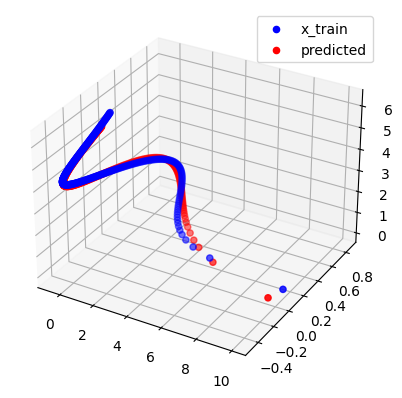

In [31]:
preds = train.predict(data)
ax = plt.axes(projection='3d')
ax.scatter3D(data[:,0], data[:,1], data[:,2], c='b' , label='x_train')
ax.scatter3D(preds[:,0], preds[:,1], preds[:,2], c='r', label='predicted')
plt.legend()
plt.show()

**Вывод:** В процессе выполнения данной лабораторной работы я научился самостоятельно реализовывать и практически применять автоассоциативные нейронные сети с узким горлом. Интересно было разбираться в тонкостях реализации данной сети. Принцип работы данных сетей позволяет решать многие нетривиальные задачи (например: распознование голоса).